# Multivariate Analysis - PLS-DA

In this notebook we will perform a supervised *multivariate* PLS-DA analysis of the *C. elegans* dataset. It is recommended to finish first the notebook *Multivariate Analysis - PCA*.

The notebook is divided in the following steps:

1) Model fitting basics: Fit PLS-DA models to predict genotype from the metabolic profile data, using different types of scaling.

2) Model cross-validation and component selection: Describe model cross-validation, parameter selection and performance assessment, including permutation testing.

3) Model interpretation: Describe some of the available variable importance metrics for PLS-DA, and highlight which variables might be important for the discrimination. Compare the selected variables with the results of an univariate analysis (performed using the notebook **Univariate Analysis**)

## Code import

Import all the packages and configure notebook plotting mode.

In [2]:
# Import the required python packages including 
# the custom Chemometric Model objects
import numpy as np
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning

from pyChemometrics.ChemometricsPLSDA import ChemometricsPLSDA
from pyChemometrics.ChemometricsScaler import ChemometricsScaler
from pyChemometrics.ChemometricsOrthogonalPLSDA import ChemometricsOrthogonalPLSDA
from pyChemometrics.plotting_utils import plotLoadings

# Use to obtain same values as in the text
np.random.seed(350)

In [40]:
# Set the data conversion warnings to appear only once to avoid repetition during CV
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [3]:
# Set the plot backend to support interactive plotting
%matplotlib notebook

## Data import

We will now import the LC-MS data with the metadata (Y variables) and feature annotation for LC-MS.

Then we split the metadata into two parts: 

X - LC-MS data matrix

Y_metadata - Metadata that will act as the response variable for the PLS-DA model

annotations - annotation for the features of the X data 

#### Metadata
Y - represents the sex of the indivitudals (0: Female, 1: Male) used as the response variable for the PLS-DA model

##### NB - If running locally, download the data from: [https://zenodo.org/doi/10.5281/zenodo.4053166](https://zenodo.org/doi/10.5281/zenodo.4053166) and change your local path in the cell below.

In [0]:
data = pd.read_csv("./../../Data/IPTC/Dementia_RPOS_XCMS.csv",delimiter=',')

In [53]:
# Split the data into X and Y
X = data.iloc[:, 13:]
Y_metadata = data.iloc[:, :13]

# Get the response variable
Y = pd.Categorical(Y_metadata['Gender']).codes

# Get the annotations for LC-MS features
names = X.columns.to_list()  # Extract names of features
annotations = pd.DataFrame()
for name in names:
      # Assay name
    rt = float(name.split('_')[0])  # Retention in seconds
    mz = name.split('_')[1]  # Mass-to-charge ratio
    mz = float(mz.split('m')[0])  # Extract only number from MZ-file
    # Create a data frame with following attributes
    line = pd.DataFrame({
        'Feature': name,
        'RT': rt,
        'm/z': mz
    }, index=[0]
    )
    annotations = pd.concat([annotations, line])  # Add line to a data frame
annotations.reset_index(inplace=True, drop=True)  # Data frame with deconstructed names

# Convert X to numpy array 
X = np.array(X)

In [4]:
# # Load the dataset
# X = np.genfromtxt("./../../Data/IPTC/X_spectra.csv", delimiter=',', dtype=None)
# Y = pd.read_csv("./data/worm_yvars.csv",delimiter=',',dtype=None, header=None)
# ppm = np.loadtxt("./data/ppm.csv",delimiter=',')
# 
# # Use pandas Categorical type to generate the dummy enconding of the Y vector (0 and 1) 
# Y1 = pd.Categorical(Y.iloc[:, 0]).codes
# Y2 = pd.Categorical(Y.iloc[:, 1]).codes

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pd.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pd.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 

Plot all the peaks in the dataset coloured by mean intesity.


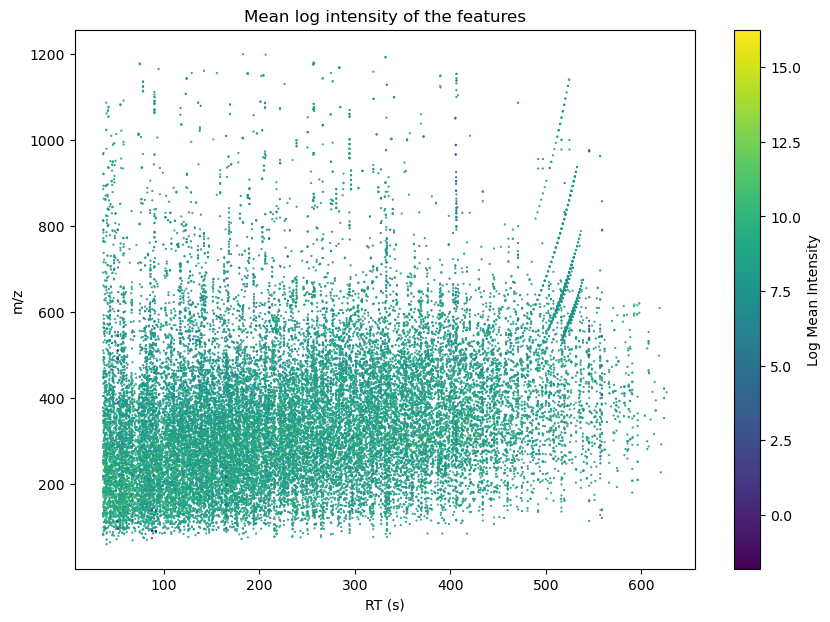

In [34]:
# Plot the RT and m/z of the features with the mean log intensity as the colour and legend bar ob the right hand side
plt.figure(figsize=(10, 7))
plt.scatter(annotations['RT'], annotations['m/z'], s=0.3, c=np.log(X.mean(axis=0)), cmap='viridis')
plt.title('Mean log intensity of the features')
plt.colorbar(label='Log Mean Intensity')
plt.xlabel('RT (s)')
plt.ylabel('m/z')
plt.show()

# PLS-DA modeling

## 1) Model fitting basics

In this section we will fit a PLS-DA model to classify *C.elegans* samples based on their genotype, and assess the metabolic differences between *sod-2* mutants and the parent wild-type (N2).

As an example, we start by fitting a PLS-DA model with 2 components and with unit-variance (UV) scaling. The choice of components to use in the modeling will be addressed properly in the next section, the objective of this first section is to introduce the model syntax.

Similar to PCA, we start by choosing a scaling method for the X data matrix. The choice of scaling method will influence the results and interpretation.

In [36]:
# Select the scaling options: 

# Unit-Variance (UV) scaling:
scaling_object_uv = ChemometricsScaler(scale_power=1)

# Pareto scaling:
scaling_object_par = ChemometricsScaler(scale_power=1/2)

# Mean Centring:
scaling_object_mc = ChemometricsScaler(scale_power=0)

For this example we will use Unit-Variance scaling (UV scaling), and start by fitting a PLS-DA model with 2 components.

In [41]:
# Create and fit PLS-DA model
pls_da = ChemometricsPLSDA(n_components=2, x_scaler=scaling_object_uv)
pls_da.fit(X, Y)

PLS models perform dimensionality reduction in a manner similar to PCA. The main difference (besides the criteria in which the components are found) is that as well as the projections for the X matrix ($T$ scores) we also have projections for the Y matrix ($U$ scores).

Model visualization of PLS/PLS-DA models is typically performed by plotting the $T$ scores (X matrix scores). 
The score plot gives an overview of the relationships between samples, their similarities and dissimilatrities within the model space.

<br>

**Warning**: PLS-DA models can easily overfit, and the degree of separation or clustering of samples from distinct classes or Y outcome in the score plot is not a reliable measure of model validity. We recommend focusing on model validation before exploring the relationships in the scores plot. See the next section.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


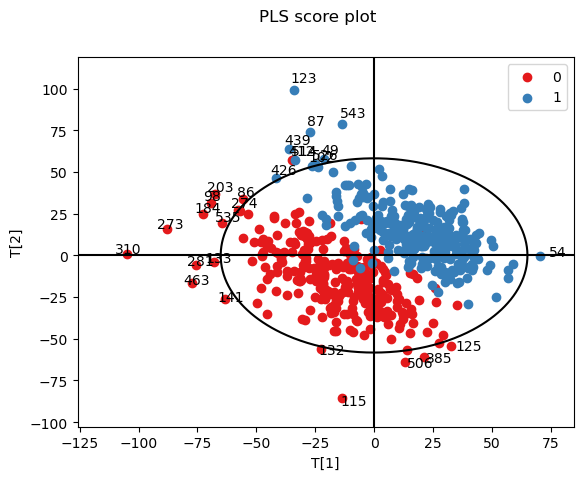

<AxesSubplot: xlabel='T[1]', ylabel='T[2]'>

In [42]:
# Plot the scores
pls_da.plot_scores(color=Y, discrete=True, label_outliers=True, plot_title=None)

The *plot_scores* methods from `ChemometricsPLS` and `ChemometricsPLSDA` objects share the same functionality as `ChemometricsPCA.plot_scores`. Score plot data points can be colored by levels of a continuous or discrete covariate by using the `color` argument, and setting the ```discrete``` argument to ```True``` or ```False```, accordingly). The index (row index of the data matrix **X**) of the outlying can be labeled with ```label_outliers=True``` and the plot title changed with the argument```plot_title```.

The main directions associated with each component in the score plots can be interpreted in terms of the original X variables using the loading vector, just like in PCA. Each component has an associated loading vector $p$ and weight vector $w$.

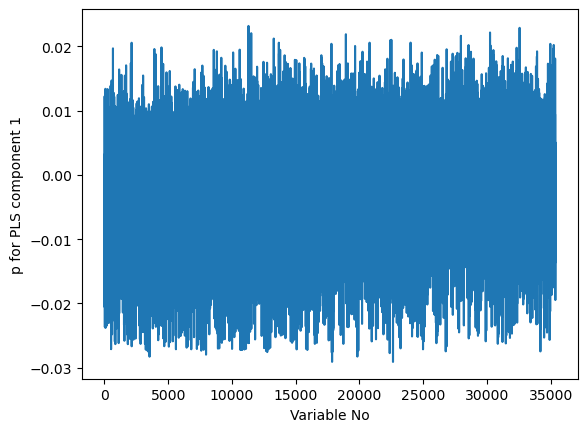

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Variable No', ylabel='p for PLS component 1'>)

In [47]:
# Plot the weights and loadings.
# w for weights, p for loadings,
# ws for X rotations (rotated version of w)

pls_da.plot_model_parameters(parameter='p', component=1)

Besides the loading vectors, PLS models have another important set of parameters, the weight vectors. There is one weight vector ($w$) corresponding to the X matrix and another ($c$) to the Y variables.

The weight vector ($w$) relates the original X variables with the Y outcome we are predicting. These vectors (and metrics based on them, such as VIP) are important to assess the relationship between X and Y and which X variables are more associated with Y. This will be discussed in more detail later in this tutorial.

The larger the magnitude of the variable coefficient in the weight vector, the more "associated" that variable is with the response.

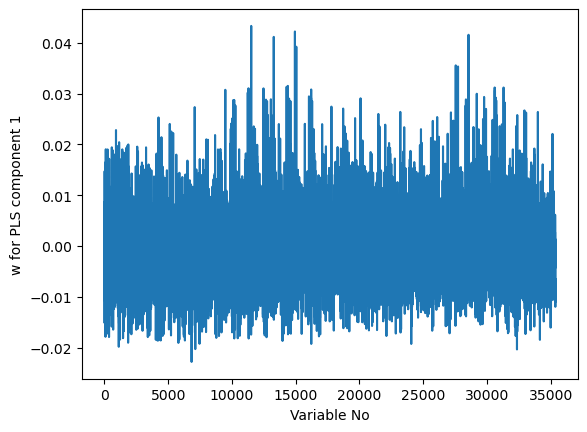

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Variable No', ylabel='w for PLS component 1'>)

In [48]:
# Plot the weights and loadings.
# w for weights, p for loadings,
# ws for X rotations (rotated version of w) 
pls_da.plot_model_parameters(parameter='w', component=1)

We can also plot the loading and weight vectors as a colourscale over the median spectrum. 

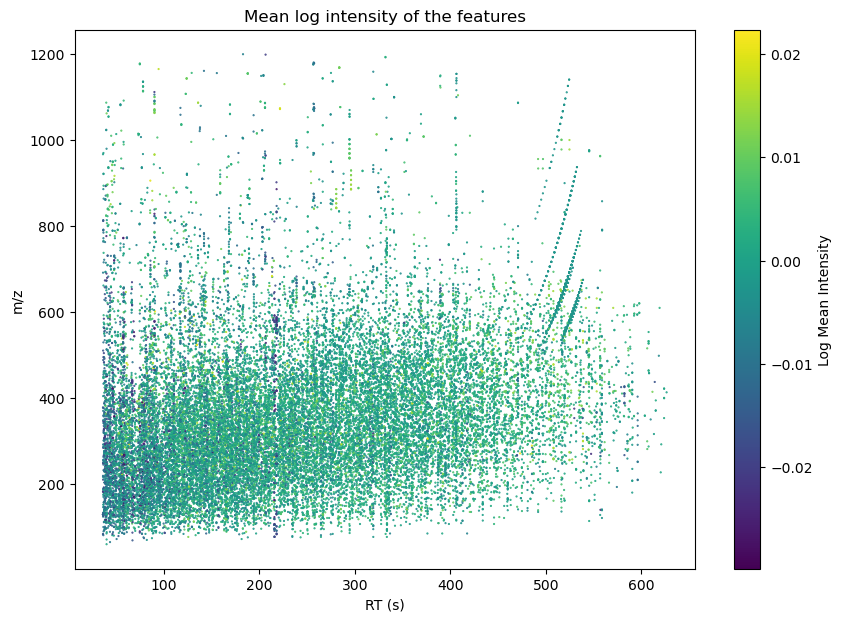

In [69]:
# Plot of weights from PLS component 1 overlaid on the median spectrum
# plotLoadings(pls_da.weights_w[:, 0], ppm, spectra=X)

# Plot the RT and m/z of the features with the mean log intensity as the colour and legend bar ob the right hand side
plt.figure(figsize=(10, 7))
plt.scatter(annotations['RT'], annotations['m/z'], s=0.3, c=pls_da.loadings_p[:, 0], cmap='viridis')
plt.title('Mean log intensity of the features')
plt.colorbar(label='Weights')
plt.xlabel('RT (s)')
plt.ylabel('m/z')
plt.show()

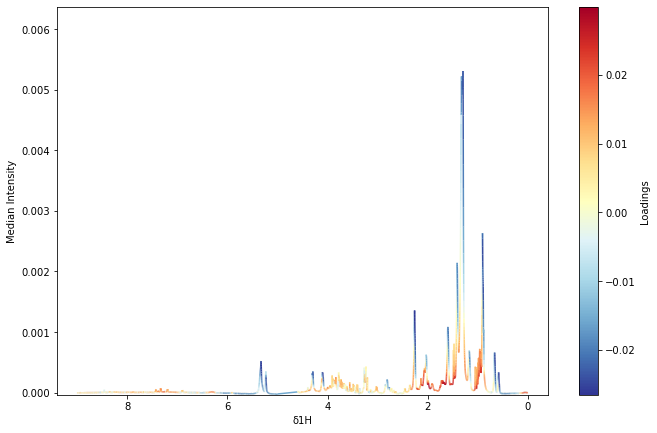

In [12]:
# Plot of loadings from PLS component 1 overlaid on the median spectrum
plotLoadings(pls_da.loadings_p[:, 0], ppm, spectra=X)

## 2) Model Selection - Number of components

Selection of the number of components for a PLS model follows a very similar logic to the PCA case.
Since the goal is to predict the Y variable, the main criteria used are the $R^{2}Y$/$Q^{2}Y$ as opposed to $R^{2}X$/$Q^{2}X$.

Ideally, we want to select enough components to predict as much of the variation in Y as possible using the data in X, while avoiding overfitting. 

We apply a similar criterion as the one used with PCA: choosing as the number of components after which the $Q^{2}Y$ value reaches a plateau (less than 5% increase compared to previous number of components). 

In [52]:
X

,39.78_60.0553m/z,43.4_65.0054m/z,66.93_68.9968m/z,81.92_70.065m/z,39.81_71.0602m/z,50.3_72.0806m/z,181.29_72.0804m/z,79.03_74.0599m/z,87.34_74.0864m/z,187.76_76.0392m/z,...,74.63_1176.3727m/z,74.61_1177.3742m/z,257.31_1177.976m/z,257.16_1178.4768m/z,257.07_1178.9772m/z,256.72_1179.4775m/z,332.04_1191.5462m/z,332.03_1192.5497m/z,206.4_1197.9501m/z,182.77_1198.8743m/z
0,0.000000,5141.886093,2111.236117,3870.661510,0.0,6923.534678,628.436605,1015.428885,0.000000,1015.179315,...,4311.601484,1637.051487,11166.844355,10940.984154,14496.270374,7708.921498,11218.859672,5717.604188,7984.616009,196.822020
1,0.000000,6017.528122,3088.552142,3661.758700,0.0,5417.595927,1627.891054,712.832651,0.000000,3674.237898,...,3317.758207,1003.786913,1748.162949,1852.975907,1493.316124,1359.072654,4434.587108,3070.116168,2673.341028,10539.927832
2,0.000000,3283.806733,4588.838502,1882.922391,0.0,9502.802694,1118.087734,1025.933961,0.000000,1475.322161,...,3075.637908,1456.356351,7487.057586,6324.053828,7275.491441,5080.064612,21852.526056,12117.905872,3489.857210,0.000000
3,0.000000,4305.315726,3156.764794,1365.043178,0.0,4732.789250,352.211083,458.348150,0.000000,1419.846006,...,5393.942809,1476.771534,1404.956398,1837.268542,1590.661281,1255.220722,5998.964225,2404.635368,2893.099974,702.379684
4,0.000000,5141.927590,3834.823055,1106.841639,0.0,9541.768190,941.931634,1568.817611,0.000000,3559.681776,...,4309.691542,1610.609151,3931.316284,3010.750908,3243.907677,2322.117025,11010.550414,5484.830159,5032.369585,2098.206502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,0.000000,2078.212068,3573.584604,5283.022549,0.0,7723.117601,586.012693,1453.571199,0.000000,743.054777,...,2613.354504,1224.515972,4274.320152,2421.451586,2900.225969,1980.616606,195.420838,53.321476,8667.998446,1487.848346
557,0.000000,1212.986195,1354.583354,2458.605468,0.0,3619.313884,261.985465,512.039305,0.000000,1770.822085,...,5460.864312,1714.789132,3145.402511,2414.687491,2308.018232,928.524702,14.010885,30.946572,5690.745518,245.668457
558,30.802955,2730.656160,3518.740207,1528.035401,0.0,6069.681643,404.328298,520.196052,0.000000,3646.976779,...,6802.178057,2830.985151,12333.320112,6438.419038,2939.468850,10072.310497,19.556300,0.000000,5090.987075,8359.530220
559,0.000000,2887.485420,4809.170443,1520.153102,0.0,7511.860652,1586.509837,1439.843657,11.592686,4846.992674,...,4150.195241,1558.711067,6631.378031,6486.727859,5170.266045,3783.653730,1891.432513,1475.509344,7074.943711,1465.193799


AUC measure stabilizes (increase of less than 5% of previous value or decrease) at component 2


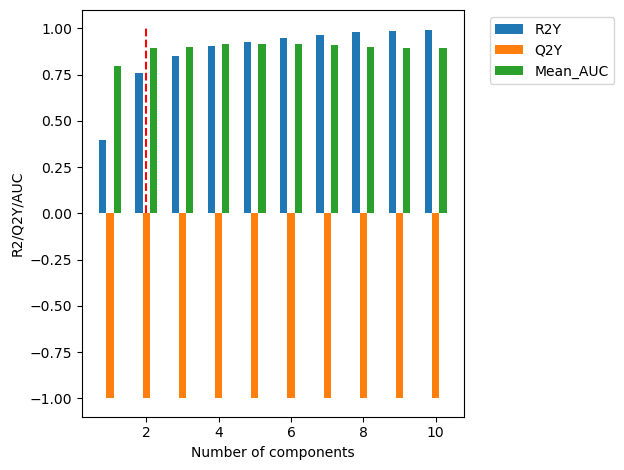

(2, <AxesSubplot: xlabel='Number of components', ylabel='R2/Q2Y/AUC'>)

In [54]:
pls_da.scree_plot(X, Y, total_comps=10)

Just like in the case of PCA, the $Q^{2}Y$ and other validation metrics obtained during K-Fold cross validation is sensitive to row permutation of the X and Y matrices. Shuffling the rows and repeating the cross-validation steps multiple times is a more reliable way to select the number of components.

**Note**: Model cross-validation, especially the *repeated_cv* call in the next cell requires fitting the model multiple times, and can take a few minutes.

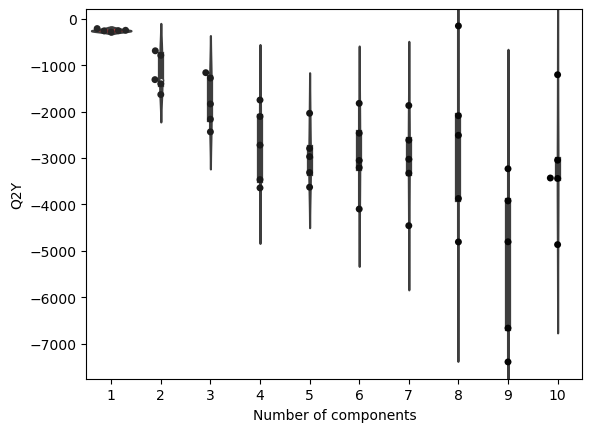

In [55]:
# Repeated cross_validation
rep_cv = pls_da.repeated_cv(X, Y, repeats=5, total_comps=10)

### Outlier detection

The outlier detection measures available for PCA (Hotelling $T^{2}$ and DmodX) are also available for PLS/PLS-DA models. Outlier interpretation is also performed in the same way.

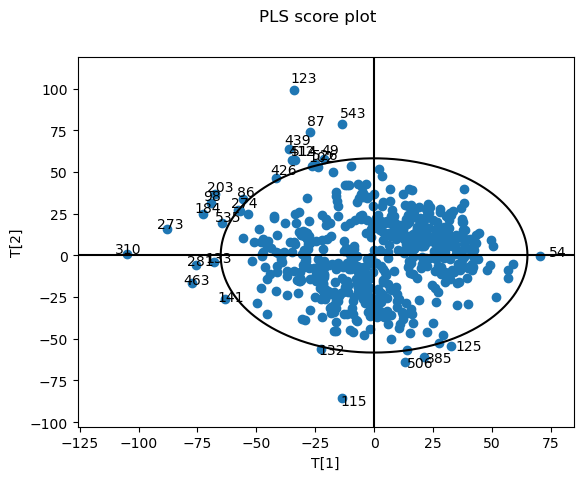

Outliers: []


In [62]:
pls_da.plot_scores(label_outliers=True)
pca_outliers = pls_da.outlier(X)
print('Outliers: {0}'.format(pca_outliers))

The strongest outliers in this case are the 5 samples with more negative PLS component 2 scores. These are actually the same samples identified as outliers during the preliminary PCA analysis. We will remove them before proceeding.

In [59]:
X = np.delete(X, pca_outliers, axis=0)
Y = np.delete(Y, pca_outliers, axis=0)

We now re-check the optimal number of components after exclusion of outliers.

AUC measure stabilizes (increase of less than 5% of previous value or decrease) at component 2


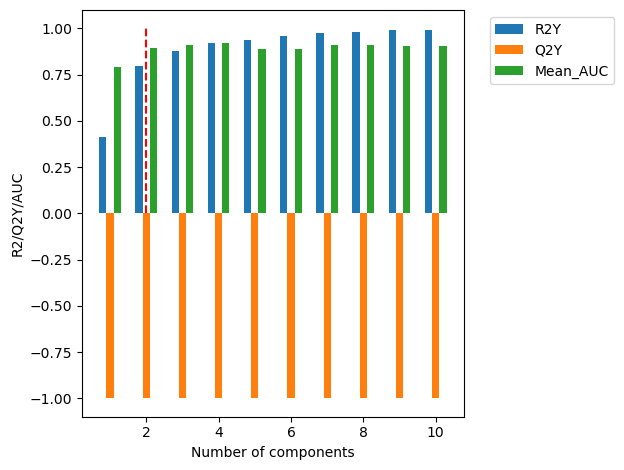

(2, <AxesSubplot: xlabel='Number of components', ylabel='R2/Q2Y/AUC'>)

In [64]:
pls_da.scree_plot(X, Y, total_comps=10)

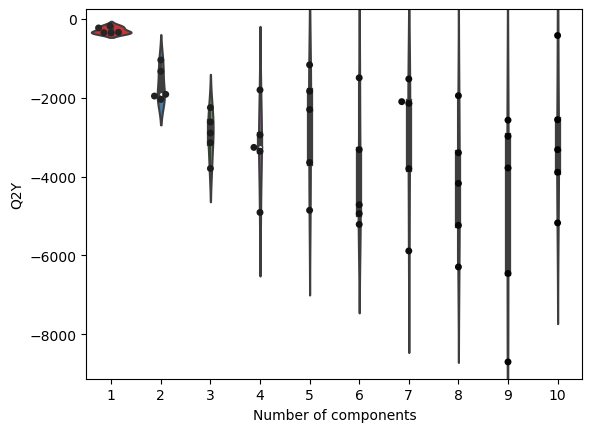

In [65]:
# Repeated cross_validation
rep_cv = pls_da.repeated_cv(X, Y, repeats=5, total_comps=10)

Following the recomendations from cross-validation and repeated cross validation we select 4 as the final number of components.

### Refit the model
Refit the model without outliers and use the number of components selected.

In [66]:
# Refit the model with the selected number of components
pls_da = ChemometricsPLSDA(n_components=3, x_scaler=scaling_object_uv)
pls_da.fit(X, Y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


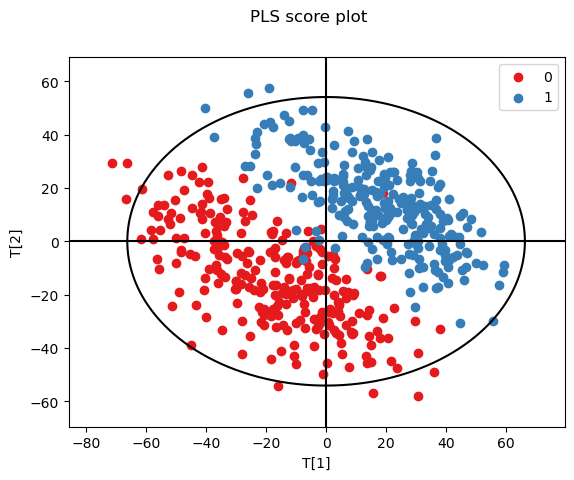

<AxesSubplot: xlabel='T[1]', ylabel='T[2]'>

In [67]:
pls_da.plot_scores(color=Y, discrete=True)

Although we used the $Q^{2}Y$ metric to perform model selection, this metric is easier to interpret for regression problems, and it is not straightforward to assess the performance of a classifier model using $Q^{2}Y$ or $R^{2}Y$ and similar goodness of fit metrics. The performance in a classification task is more effectively described by confusion matrices and related metrics, such as accuracy/balanced accuracy, f1, ROC curves and their respective area under the curve.

To obtain more reliable estimates we can calculate the cross-validation estimates of any of these metrics, including cross-validated ROC curves. This ROC curve was estimated using the left-out samples (the test sets) during cross-validation.

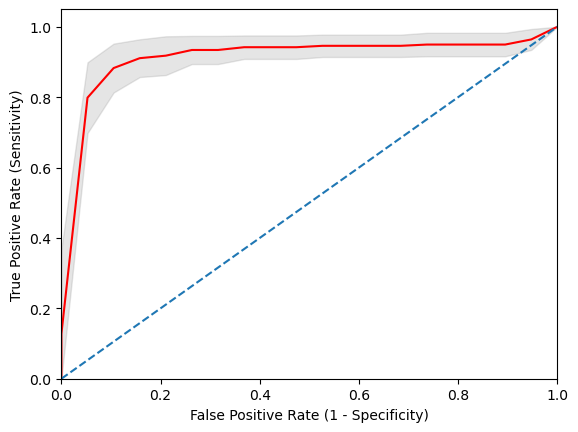

Mean AUC: [0.91109134]


<AxesSubplot: xlabel='False Positive Rate (1 - Specificity)', ylabel='True Positive Rate (Sensitivity)'>

In [68]:
# Cross-validated ROC curve
pls_da.cross_validation(X, Y)
pls_da.plot_cv_ROC()

### Permutation Testing
A final and very important method for model validation is the permutation randomization test. In a permutation randomisation test, the model will be refitted and assessed multiple times, but each time with the Y randomly permuted to destroy any relationship between X & Y. This allows us to assess what sort of model we can get when there really is no relationship between the two data matrices, and calculate the likelihood of obtaining a model with predictive performance as good as the non-permuted model by chance alone.

During this test, the number of components, scaling, type of cross-validation employed, and any other modeling choice is kept constant. In each randomization, the model is refitted, and the AUC, $Q^{2}Y$ or any other validation metric is recorded. This enables the generation of permuted null distributions for any parameter, which can be used to obtain an empirical *p-value* for their significance.

**Note** Running the permutation test with a large number of permutation randomizations (for example, 1000) is expected to take a considerable ammount of time (approximately 30 mins on a laptop).

In [ ]:
# permt = pls_da.permutation_test(X, Y1, 1000)

#### Optional: Load pre-calculated results

In [32]:
# np.save('./../../Data/IPTC/permutations_plsda.npy', permt)


permt = np.load('./../../Data/IPTC/permutations_plsda.npy', allow_pickle=True)

# Gonsaloses file sharing link
# !wget "https://drive.google.com/u/0/uc?id=1KsjAnaYQ0aJfLDExYRNXO5E1Y0XvRvqf&export=download&confirm=t&uuid=d1c8bfb9-3f76-4a85-a931-8d0785a8aecd&at=ALt4Tm1Zil7479CL_Xq3Anjkij7S:1689083835165" -O "permutations_plsda.npy"

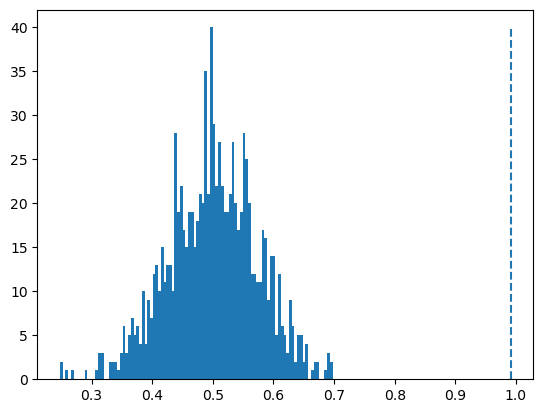

Permutation p-value for the AUC: 0.000999000999000999


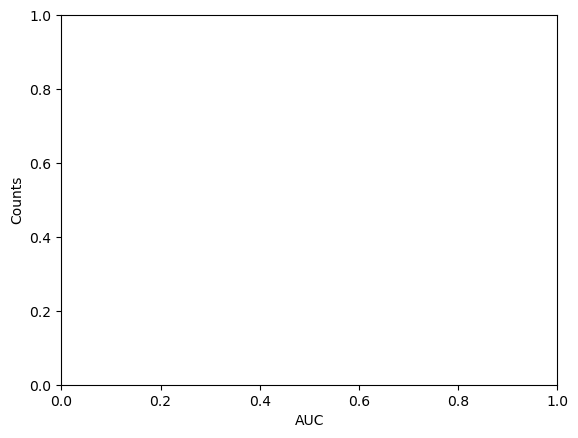

In [34]:
# plot the results from the permuation test
pls_da.plot_permutation_test(permt, metric='AUC')
plt.xlabel('AUC')
plt.ylabel('Counts')
print("Permutation p-value for the AUC: {0}".format(permt[1]['AUC']))

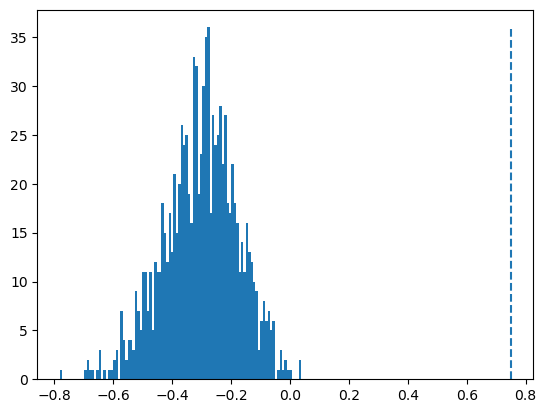

Permutation p-value for the Q2Y: 0.000999000999000999


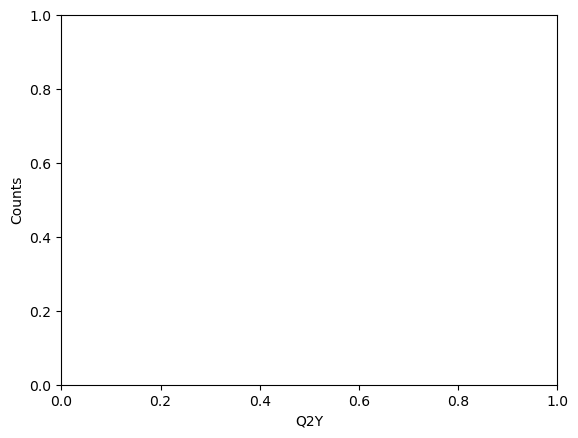

In [35]:
# plot the results from the permuation test
pls_da.plot_permutation_test(permt, metric='Q2Y')
plt.xlabel('Q2Y')
plt.ylabel('Counts')
print("Permutation p-value for the Q2Y: {0}".format(permt[1]['Q2Y']))

The *p-value* obtained is < 0.05, so the model AUC and Q2Y values are significantly different from what is expected by chance alone at a level of $\alpha$ = 0.05.

## 3) Model interpretation and variable importance

The main parameters to assess in terms of variable importance for the prediction of Y from X are the weights ($w$), the VIP metric and regression coefficients.

The values in a weight vector vary between -1 (strong negative-covariance) and 1 (strong covariance), with 0 meaning no association/covariance. The weight vector of the first component (which explains the most variation in Y) is the primary weight vector to analyze when interpreting the main variables of X associed with Y.

The variable importance for prediction (VIP) metric is a sum (weighted by the ammount of variance of Y explained by each respective component) of the squared weight values. It provides a summary of the importance of a variable accounting for all weight vectors. VIPs are bounded between 0 (no effect) and infinity. Because it is calculated from the weights $w$, for PLS models with a single component these are directly proportional to the $w^{2}$. The VIP metric has the disadvantage of pooling together $w$ vectors from components which contribute a very small magnitude to the model's $R^{2}Y$.

The regression coefficients ($\beta$) have a similar interpretation as regression coefficients in a multivariate/multiple linear regression.

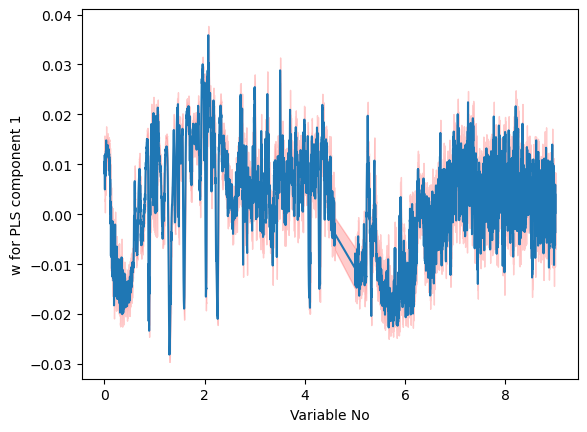

Text(0.5, 0, 'ppm')

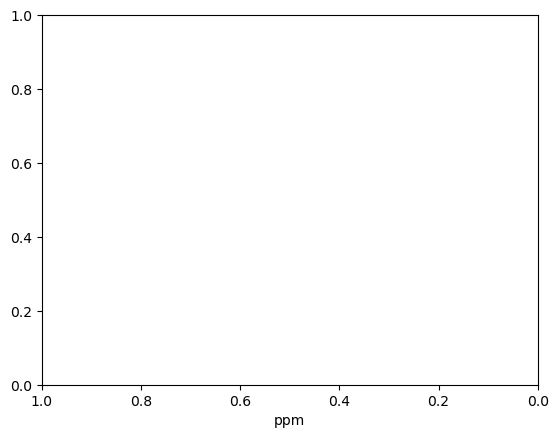

In [36]:
pls_da.plot_model_parameters('w', component=1, sigma=2, cross_val=True, xaxis=ppm)
plt.gca().invert_xaxis()
plt.gca().set_xlabel('ppm')

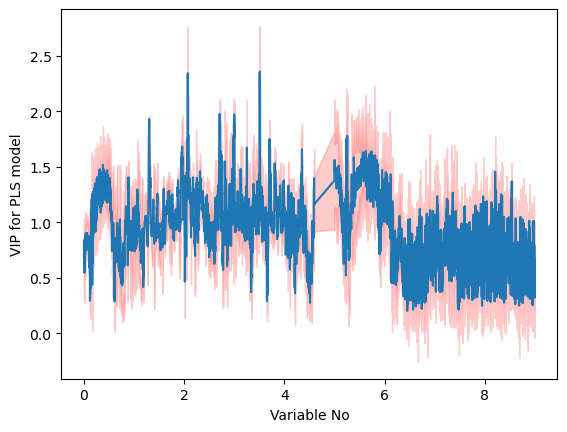

Text(0.5, 0, 'ppm')

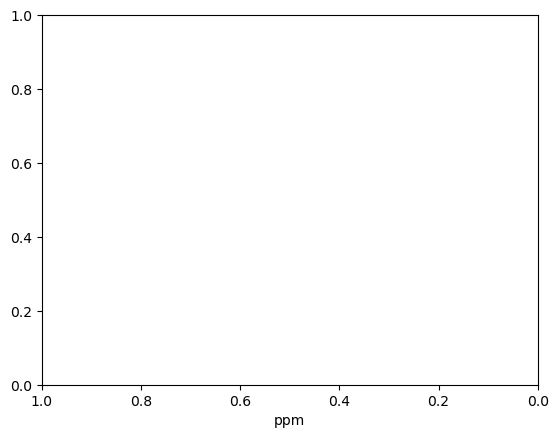

In [37]:
pls_da.plot_model_parameters('VIP', sigma=2, cross_val=True, xaxis=ppm)
plt.gca().invert_xaxis()
plt.gca().set_xlabel('ppm')


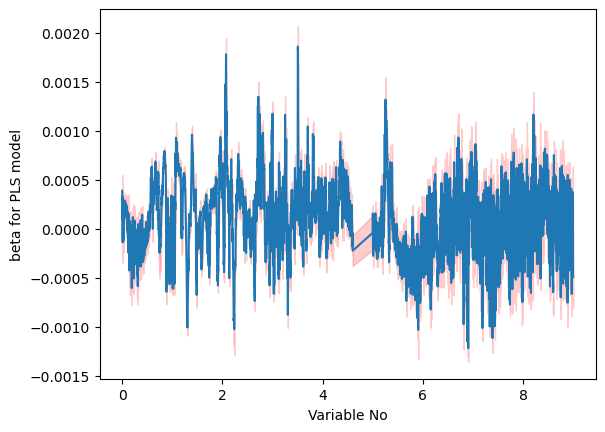

Text(0.5, 0, 'ppm')

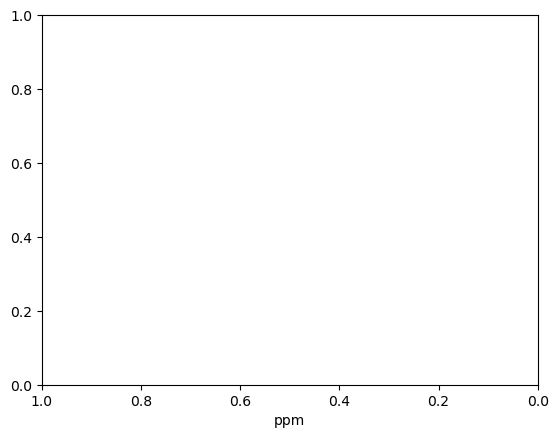

In [38]:
pls_da.plot_model_parameters('beta', sigma=2, cross_val=True, xaxis=ppm)
plt.gca().invert_xaxis()
plt.gca().set_xlabel('ppm')

Unfortunately, assessment of variable importance in PLS-DA/PLS multivariate models is not straightfoward, given the multiple choice of parameters and their different interpretation, especially in models with more than 1 PLS component. To obtain a ranking of variables from the data matrix X associated with Y, we recommend starting with the weights $w$ of the first component, which contributes the most to $R^{2}Y$. 

However, it must be mentioned that the weights of the first PLS component are equal to the normalized (so that the weight vector has norm equal to 1) vector of the univariate covariances estimated between each X column or variable, and the Y vector. This implies there is no advantage in using a PLS model and $w$ when compared to a series of univariate analyses for variable ranking and selection.

/var/folders/h9/wwgxs6y56wq9932zk_bl77sw0000gp/T/ipykernel_7411/895382641.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


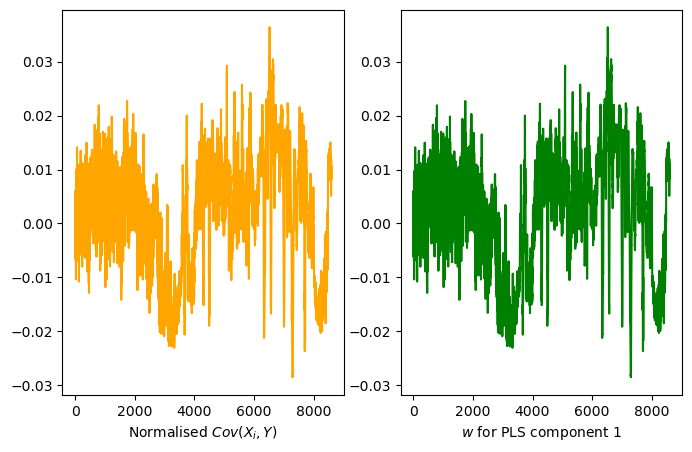

In [39]:
fig, ax = plt.subplots(1,2, figsize=(8, 5))
X_scaled = pls_da.x_scaler.transform(X)

cov_x_y = np.dot(Y1.T - Y1.mean(), X_scaled) / (Y1.shape[0]-1)
cov_x_y = cov_x_y/np.linalg.norm(cov_x_y)

ax[0].plot(cov_x_y, 'orange')
ax[1].plot(pls_da.weights_w[:, 0], 'green')
ax[0].set_xlabel('Normalised $Cov(X_{i}, Y)$')
ax[1].set_xlabel('$w$ for PLS component 1')
fig.show()

Another set of quantities which can be used to assess variable importance are the $\beta$ regression coefficients. However, as with other multivariate regression models, the final $\beta$ vector encodes information about the correlation structure of X and how it relates to Y, and the magnitude and sign of $\beta$ coefficient express how to derive a "good" prediction of Y using X. Taking the magnitude of each $\beta$ and using it to rank variables can be misleading.

This does not mean necessarily that PLS should only be used as a predictive "black box" regressor/classifier and model interpretation avoided altogether. The strength of PLS for exploratory data analysis and interpretation resides on the latent variable projections. The scores $T$ or $U$ can be plotted and associated with other metadata variables, or even correlated or regressed against them, and the corresponding loading $p$ can be visualized to assess the signals which make up the latent variable signature.

For example, if we inspect the scores plot for components 2 and 3 it becomes apparent that although we have not added information about the Age covariate to the model, the PLS component number 3 seems to be associated with it. This hints that this component is accounting for some of the variability related with Age to improve the prediction. The loadings of this component can then be used to visualize which regions of the spectrum are correlated. 

**Note**: We recommend refering to loadings $p$ and not weights $w$ when interpreting latent variable signatures, especially in PLS components after the 1st component.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


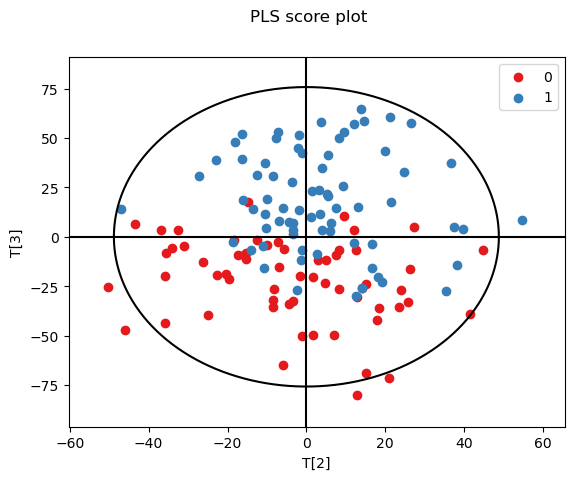

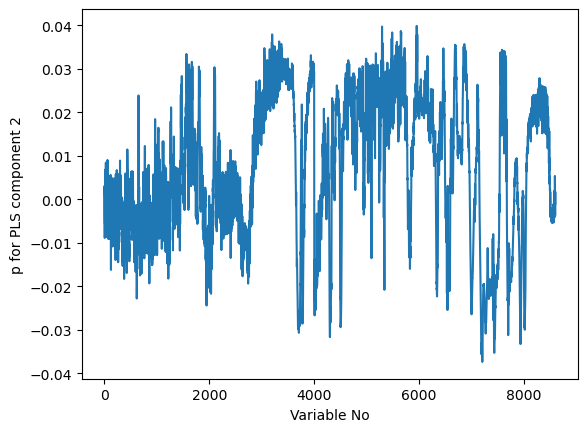

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='Variable No', ylabel='p for PLS component 2'>)

In [40]:
# Same model, but coloured by Age instead of Genotype
pls_da.plot_scores(comps=[1, 2], color=Y2, discrete=True)
pls_da.plot_model_parameters('p', component=2)

### Orthogonal PLS

The orthogonal PLS modeling technique can be used to assist intepretation of PLS latent variables.
After obtaining a reliable PLS model, we generate an Orthogonal PLS/PLS-DA model with the same number of components as the PLS model. In an orthogonal PLS model, the first component is called predictive, and the subsequent components "orthogonal" because they are uncorrelated to the response Y. Compared to the equivalent PLS model, Orthogonal PLS models shuffle away variation from the loading vector $p$ of the first component to subsequent components, which can aid in interpretation of the latent variables.

In [41]:
# Generate an Orthogonal PLS-DA version of the PLS-DA model fitted
orthogonal_pls_da = ChemometricsOrthogonalPLSDA(ncomps=5, xscaler=scaling_object_uv)
orthogonal_pls_da.fit(X, Y1)

The Orthogonal PLS model we just fitted has 1 predictive component and 4 orthogonal components. The predictive component encodes the information in X directly associated with Y. 
The orthogonal components can be investigated and associated with other known covariates, to assist in understanding the sources of variation that the PLS model/Orthogonal PLS model is "learning" from the data to improve the prediction of Y (measured by the $R^{2}Y$)

In the following plot, we investigate the scores on the predictive ($T_{pred}$) and first orthogonal component ($T_{ortho[1]}$), coloured by genotype.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


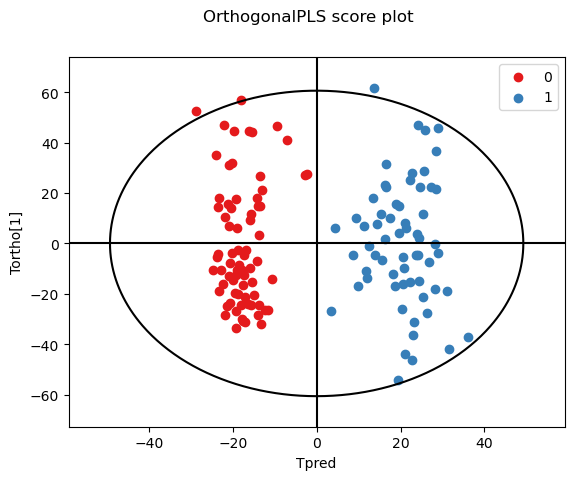

<AxesSubplot: xlabel='Tpred', ylabel='Tortho[1]'>

In [42]:
orthogonal_pls_da.plot_scores(color=Y1, orthogonal_component=1, discrete=True)

The analysis of orthogonal component 2 hints that age (Y2) contributes orthogonal variation to the data. Note: in the plot below, the data points are coloured by age (Y2).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


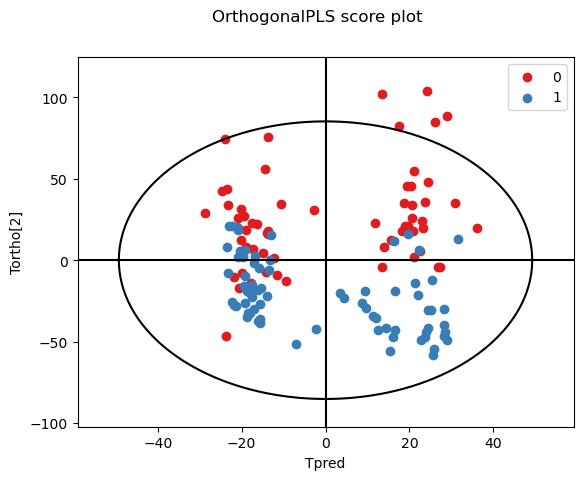

<AxesSubplot: xlabel='Tpred', ylabel='Tortho[2]'>

In [43]:
orthogonal_pls_da.plot_scores(color=Y2, orthogonal_component=2, discrete=True, label_outliers=False)

The interpretation of the Orthogonal PLS score plorts model should be made using the predictive and orthogonal loading vectors ($p$) for all components. Only the weight vector $w$ for the predictive component should be evaluated.

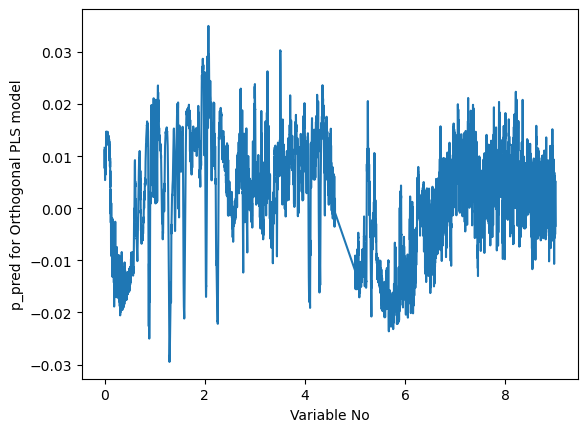

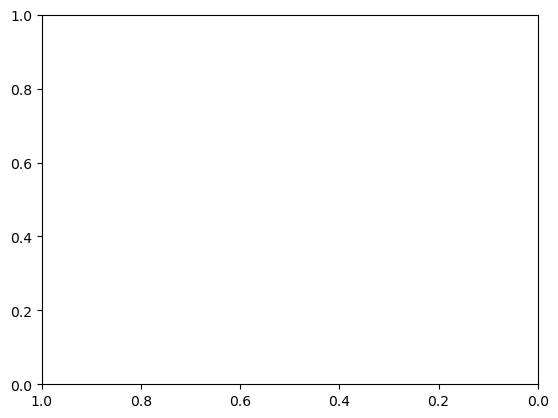

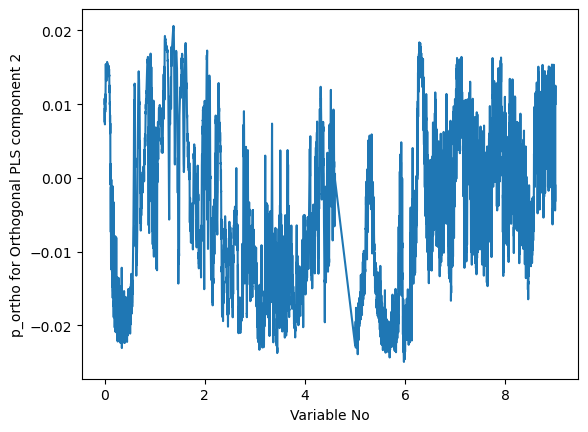

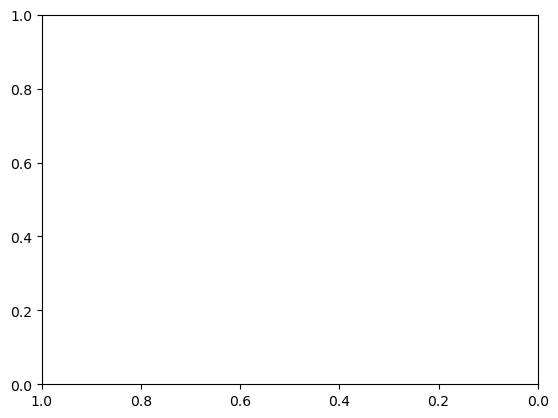

In [44]:
orthogonal_pls_da.plot_model_parameters('p_pred', orthogonal_component = 1, xaxis=ppm)
plt.gca().invert_xaxis()
# 
orthogonal_pls_da.plot_model_parameters('p_ortho', orthogonal_component = 2, xaxis=ppm)
plt.gca().invert_xaxis()

## Permutation p-values for variable ranking

The permutation test we ran before is also useful to obtain permuted null distributions for most of the model parameters. These can be used to obtain empirical confidence intervals and potentially permutation *p-values* for hypothesis testing.

To illustrate this, the next cells generate histograms for the permuted distribution of the $w$ and $p$ for the first PLS component and regression coefficients for 2 randomly selected variables.
Notice the differences between the permuted null distributions of weights, loadings and regression coefficients. 

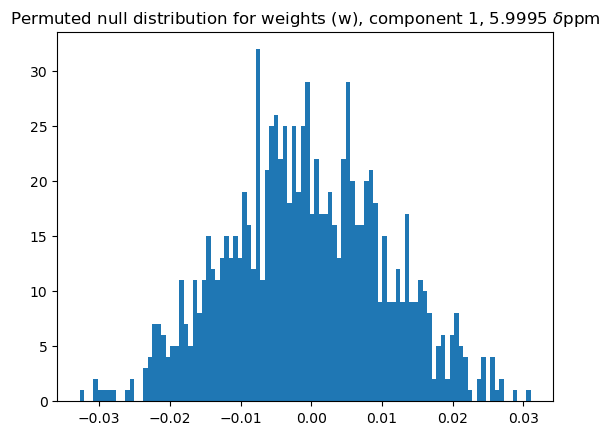

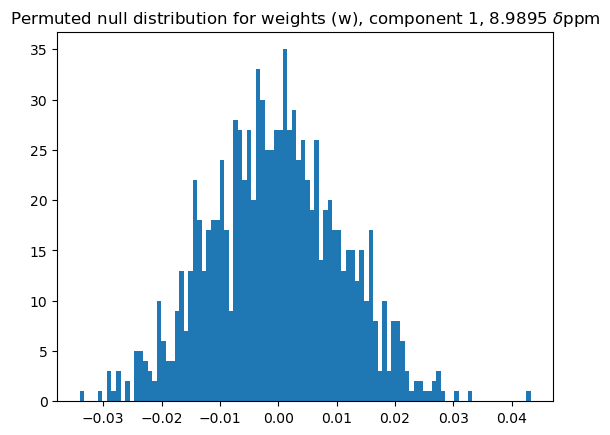

In [45]:
# Plot empirical null distributions for weights
plt.figure()
plt.hist(permt[0]['Weights_w'][:, 3000, 0], 100)
plt.title("Permuted null distribution for weights (w), component 1, {0} $\delta$ppm".format(ppm[3000]))
plt.show()

plt.figure()
plt.hist(permt[0]['Weights_w'][:, 10, 0], 100)
plt.title("Permuted null distribution for weights (w), component 1, {0} $\delta$ppm".format(ppm[10]))
plt.show()

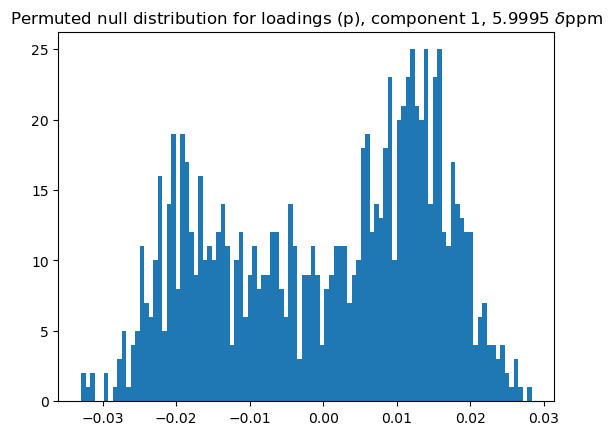

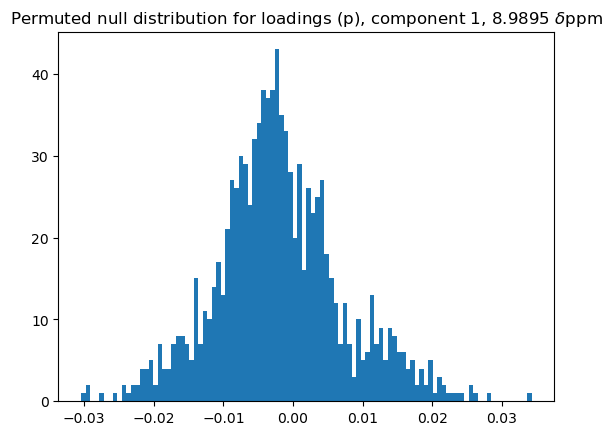

In [46]:
# Plot empirical null distributions for loadings
# Notice how these are not unimodal and distributed around 0...
plt.figure()
plt.hist(permt[0]['Loadings_p'][:, 3000, 0], 100)
plt.title("Permuted null distribution for loadings (p), component 1, {0} $\delta$ppm".format(ppm[3000]))
plt.show()

plt.figure()
plt.hist(permt[0]['Loadings_p'][:, 10, 0], 100)
plt.title("Permuted null distribution for loadings (p), component 1, {0} $\delta$ppm".format(ppm[10]))
plt.show()

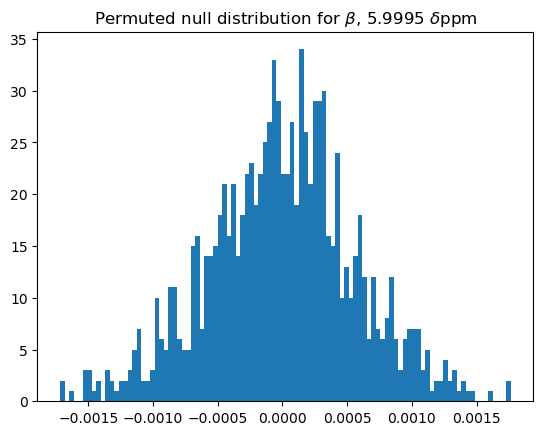

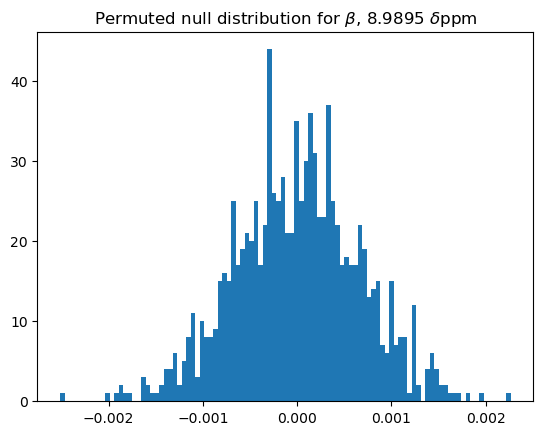

In [47]:
# Plot empirical null distributions for regression coefficients
plt.figure()
plt.hist(permt[0]["Beta"][:, 3000], 100)
plt.title(r"Permuted null distribution for $\beta$, {0} $\delta$ppm".format(ppm[3000]))
plt.show()

plt.figure()
plt.hist(permt[0]['Beta'][:, 10], 100)
plt.title(r"Permuted null distribution for $\beta$, {0} $\delta$ppm".format(ppm[10]))
plt.show()

Both the regression coefficients and weights have a null distribution centered around 0. Conversely, for the loadings, the center of the distribution is shifted. Loadings encode information about the variance and covariance (with the latent variable score) of each variable, and their magnitude is harder to interpret in terms of importance for prediction. The permutation performed in this manner does not change the correlation between variables in X, and therefore is not adequate to obtain permuted null distributions of the loading parameters.

We can now calculate empirical p-values for the regression coefficients...

In [48]:
# Always set *nperms* equal to the number of permutations used before
nperms = permt[0]['R2Y'].size
perm_indx = abs(permt[0]['Beta'].squeeze()) >= abs(pls_da.beta_coeffs.squeeze())
counts = np.sum(perm_indx, axis=0)
beta_pvals = (counts + 1) / (nperms + 1)

perm_indx_W = abs(permt[0]['Weights_w'][:, :, 0].squeeze()) >= abs(pls_da.weights_w[:, 0].squeeze())
counts = np.sum(perm_indx_W, axis=0)
w_pvals = (counts + 1) / (nperms + 1)

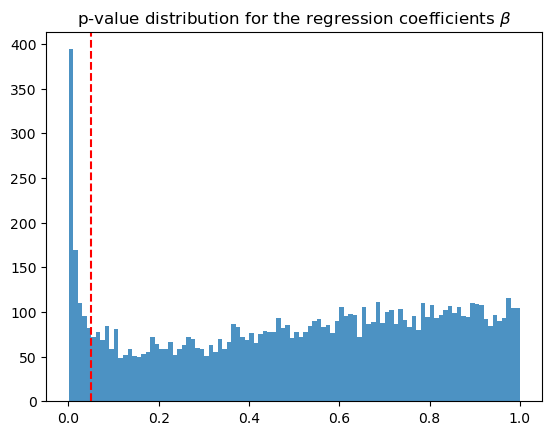

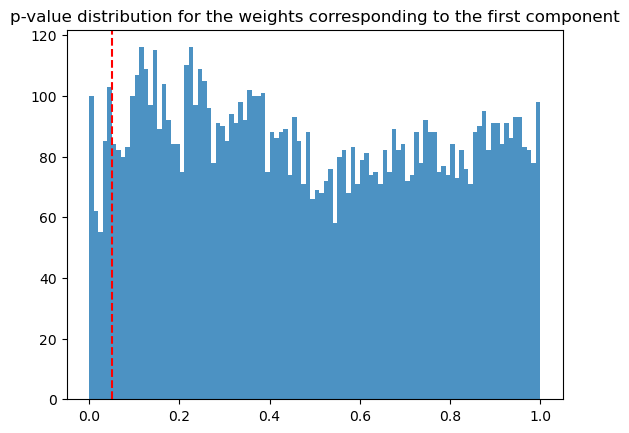

In [49]:
plt.figure()
plt.title(r"p-value distribution for the regression coefficients $\beta$ ")
z = plt.hist(beta_pvals, bins=100, alpha=0.8)
plt.axvline(x=0.05, ymin=0, ymax=max(z[0]), color='r', linestyle='--') 
plt.show()

plt.figure()
plt.title(r"p-value distribution for the weights corresponding to the first component")
z = plt.hist(w_pvals, bins=100, alpha=0.8)
plt.axvline(x=0.05, ymin=0, ymax=max(z[0]), color='r', linestyle='--') 
plt.show()

... and use the permutation test to obtain a list of statistically significant variables.

In [50]:
signif_bpls_idx = np.where(beta_pvals <= 0.05)[0]

print("Number of significant values: {0}".format(len(signif_bpls_idx)))

Number of significant values: 850


It is worth noting that a selection procedure of this kind is also a type of multiple testing, and it is recommended to apply false discovery rate or any other multiple testing correction to the *p-values* obtained in this manner. Also, formal inferential procedures to derive *p-values* and confidence intervals are not established for PLS models. Although *ad-hoc* solutions like a permutation test can be implemented as shown, some issues still remain - for example, the *p-value* distribution obtained for the regression coefficients is clearly non-uniform and care must be exercised when performing multiple testing correction or even interpreting the *p-values* obtained in this manner.

The latent variable and dimensionality reduction provided by PLS/PLS-DA can be very usefull to visualize general trends in the data. However, interpreting which variables are important to the model and how they contribute for the explanation/separation between classes is not easy. We suggest complementing the inspection of multivariate model parameters with univariate analysis.

### Comparison between variables highlighted in a multivariate PLS-DA analysis with a univariate analysis.

The following cells should be run after completing the analyses described in the **Univariate Analysis** Jupyter Notebook.

Load the results of an equivalent univariate analysis of associations between metabolic signals and genotype.

In [51]:
#load the results of the univariate testing procedure
univ_gen = pd.read_csv('./data/UnivariateAnalysis_Genotype.csv')

# Select significant peaks from univariate analysis 
signif = np.where(univ_gen['genotype_q-value'] < 0.05)[0]

We then plot the overlap between the PLS-DA classifer for Genotype and the results of an univariate analysis against genotype.

In [52]:
# p-values significant for association with genotype in both the PLS analysis and linear regression
common_idx = np.array([x for x in signif_bpls_idx if x in signif])
# p-values significant only in PLS
pls_idx = np.array([x for x in signif_bpls_idx if x not in signif])
# p-values significant only for linear regression
reg_idx = np.array([x for x in signif if x not in signif_bpls_idx])

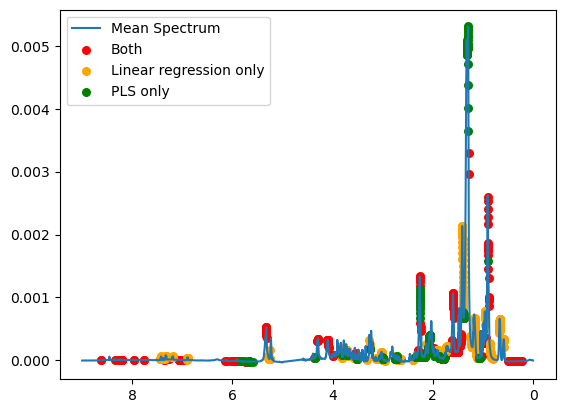

In [53]:
plt.figure()
plt.plot(ppm, X.mean(axis=0))
#plt.scatter(ppm[signif], X.mean(axis=0)[signif], c='red', s=30)
plt.scatter(ppm[reg_idx], X.mean(axis=0)[reg_idx], c='red', s=30)
plt.scatter(ppm[pls_idx], X.mean(axis=0)[pls_idx], c='orange', s=30)
plt.scatter(ppm[common_idx], X.mean(axis=0)[common_idx], c='green', s=30)
plt.gca().invert_xaxis()
plt.legend(['Mean Spectrum', 'Both', 'Linear regression only', 'PLS only'])
plt.show()